**1. installation des packages**

In [5]:
import os
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

In [13]:
LABELIMG_PATH = os.path.join("./data")
Label_me_path = os.path.join("./labelImg/")

In [70]:
cap = cv2.VideoCapture(0)
trigger = False
number_imgs = 40
i = 0
while True:
    _,frame = cap.read()

    cv2.imshow("frame",frame)
    if trigger and i < number_imgs :
        cv2.imshow("frame",frame)
        cv2.imwrite(os.path.join(LABELIMG_PATH,f"barcode{i}.png"),frame)
        time.sleep(1)
        i += 1
    key = cv2.waitKey(1)
    if key == ord("p"):
        trigger = not trigger
    if key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [14]:
!git clone https://github.com/tzutalin/labelImg {Label_me_path}

Cloning into './labelImg'...


In [18]:
!cd {Label_me_path} && pyrcc5 -o libs/resources.py resources.qrc

In [71]:
!cd {Label_me_path} && python labelImg.py

Image:C:\Users\dell\Desktop\BarcodeDetection\data\barcode0.png -> Annotation:C:/Users/dell/Desktop/BarcodeDetection/data\barcode0.xml
Image:C:\Users\dell\Desktop\BarcodeDetection\data\barcode1.png -> Annotation:C:/Users/dell/Desktop/BarcodeDetection/data\barcode1.xml
Image:C:\Users\dell\Desktop\BarcodeDetection\data\barcode2.png -> Annotation:C:/Users/dell/Desktop/BarcodeDetection/data\barcode2.xml
Image:C:\Users\dell\Desktop\BarcodeDetection\data\barcode3.png -> Annotation:C:/Users/dell/Desktop/BarcodeDetection/data\barcode3.xml
Image:C:\Users\dell\Desktop\BarcodeDetection\data\barcode4.png -> Annotation:C:/Users/dell/Desktop/BarcodeDetection/data\barcode4.xml
Image:C:\Users\dell\Desktop\BarcodeDetection\data\barcode5.png -> Annotation:C:/Users/dell/Desktop/BarcodeDetection/data\barcode5.xml
Image:C:\Users\dell\Desktop\BarcodeDetection\data\barcode6.png -> Annotation:C:/Users/dell/Desktop/BarcodeDetection/data\barcode6.xml
Image:C:\Users\dell\Desktop\BarcodeDetection\data\barcode7.png

**2. traitements des données**

In [76]:
data_dir = "./data"

In [77]:
for path in os.listdir(data_dir):
    if path.endswith(".xml"):
        xml_path = os.path.join(data_dir,path)
        tree = ET.parse(xml_path)
        root = tree.getroot()
        file_name = root.find("filename").text
        try:                
            x_min = root.find("object/bndbox/xmin").text
            y_min = root.find("object/bndbox/ymin").text
            x_max = root.find("object/bndbox/xmax").text
            y_max = root.find("object/bndbox/ymax").text
            object = tuple((file_name,"1",x_min,y_min,x_max,y_max,"\n"))
            with open("annotation_new_data.csv","a") as file:
                file.writelines(",".join(object))
        except:
            object = tuple((file_name,"0","0.0","0.0","0.00001","0.0001","\n"))
            with open("annotation_new_data.csv","a") as file:
                file.writelines(",".join(object))
            


In [78]:
data_frame = pd.read_csv("./annotation_new_data.csv",index_col=False)
data_frame = data_frame.sample(frac=1)
data_frame.head()

,image,classe,x_min,y_min,x_max,y_max
2,barcode10.png,1,255.0,312.0,313.00000,354.0000
27,barcode33.png,1,221.0,332.0,272.00000,370.0000
62,barcode65.png,0,0.0,0.0,0.00001,0.0001
12,barcode2.png,1,124.0,235.0,198.00000,287.0000
38,barcode43.png,0,0.0,0.0,0.00001,0.0001


In [79]:
data_frame.classe.value_counts()

0    41
1    40
Name: classe, dtype: int64

In [80]:
data_frame.shape

(81, 6)

In [81]:
train_size = int(data_frame.shape[0]*0.7)
print(train_size)
val_size = train_size + int(data_frame.shape[0]*0.2)
print(val_size)
test_size = val_size + int(data_frame.shape[0]*0.1) + 1 
print(test_size)
train_size + val_size + test_size

56
72
81


209

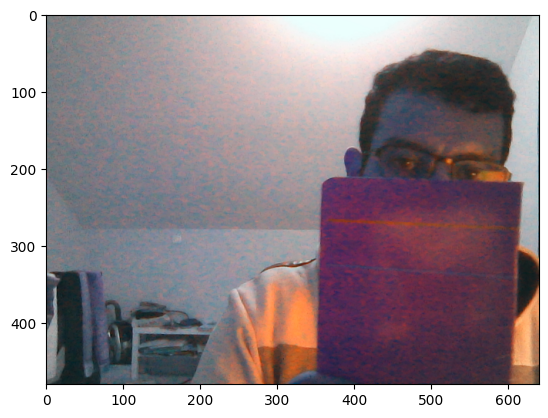

In [83]:
row = data_frame.iloc[62]
image_path = os.path.join(data_dir,row.image)
image = cv2.imread(image_path)
cv2.rectangle(image,(row.x_min.astype("int"),row.y_min.astype("int")),(row.x_max.astype("int"),row.y_max.astype("int")),(255,0,0),2)
plt.imshow(image)

**3. appliquer une augmentation des données**

In [84]:
import albumentations as alb

In [85]:
augmented_data = alb.Compose([
    alb.RandomCrop(450,450),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5)],
    bbox_params = alb.BboxParams(format="albumentations",label_fields=["class_labels"])
)
augmented_data

Compose([
  RandomCrop(always_apply=False, p=1.0, height=450, width=450),
  HorizontalFlip(always_apply=False, p=0.5),
  RandomBrightnessContrast(always_apply=False, p=0.2, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
  RandomGamma(always_apply=False, p=0.2, gamma_limit=(80, 120), eps=None),
  RGBShift(always_apply=False, p=0.2, r_shift_limit=(-20, 20), g_shift_limit=(-20, 20), b_shift_limit=(-20, 20)),
  VerticalFlip(always_apply=False, p=0.5),
], p=1.0, bbox_params={'format': 'albumentations', 'label_fields': ['class_labels'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})

In [86]:
def augmente_data(image,image_path,coords,partition,nbr_image):
    try:
        for x in range(nbr_image):
            augmentor = augmented_data(image=image,bboxes=[coords],class_labels=["barcode"])
            if bool(augmentor["bboxes"]):                    
                cv2.imwrite(os.path.join("aug_data",partition,f'{image_path.split(".")[0]}.{x}.png'),augmentor["image"])
                if len(augmentor["bboxes"]) == 0:
                    annot = [f'{image_path.split(".")[0]}.{x}.png',"0","0","0","0","0","\n"]
                else:
                    x_min,y_min,x_max,y_max = augmentor["bboxes"][0]
                    annot = [f'{image_path.split(".")[0]}.{x}.png',str(x_min),str(y_min),str(x_max),str(y_max),"1","\n"]
            else:
                cv2.imwrite(os.path.join("aug_data",partition,f'{image_path.split(".")[0]}.{x}.png'),augmentor["image"])
                annot = [f'{image_path.split(".")[0]}.{x}.png',"0","0","0","0","0","\n"]

            with open(f"aug_annot_{partition}.csv","a") as file:
                file.writelines(",".join(annot))
    except Exception as e:
        print(e)

In [87]:
number_images_generated = 68
for e,row in data_frame.iterrows():
    image = cv2.imread(os.path.join(data_dir,row.image))
    image_path = row.image
    h,w = image.shape[:2]
    coords = tuple((row.x_min,row.y_min,row.x_max,row.y_max))
    coords = np.divide(coords,(w,h,w,h))
    if e < train_size:
        augmente_data(image,image_path,coords,"train",number_images_generated)
    if e >= train_size and e < val_size:
        augmente_data(image,image_path,coords,"val",number_images_generated)
    if e >=val_size and e < test_size:
        augmente_data(image,image_path,coords,"test",number_images_generated)

**4. tester les données augmenter**

In [92]:
aug_data_frame = pd.read_csv("./aug_annot_train.csv",index_col=False)
aug_data_frame

,image,x_min,y_min,x_max,y_max,classe
0,barcode10.0.png,0.293333,0.688889,0.422222,0.782222,1
1,barcode10.1.png,0.404444,0.662222,0.533333,0.755556,1
2,barcode10.2.png,0.540000,0.253333,0.668889,0.346667,1
3,barcode10.3.png,0.380000,0.257778,0.508889,0.351111,1
4,barcode10.4.png,0.348889,0.222222,0.477778,0.315556,1
...,...,...,...,...,...,...
3803,barcode42.63.png,0.000000,0.000000,0.000000,0.000000,0
3804,barcode42.64.png,0.000000,0.000000,0.000000,0.000000,0
3805,barcode42.65.png,0.000000,0.000000,0.000000,0.000000,0
3806,barcode42.66.png,0.000000,0.000000,0.000000,0.000000,0


In [93]:
aug_data_frame.classe.value_counts()

1    2401
0    1407
Name: classe, dtype: int64

image     barcode33.32.png
x_min             0.435556
y_min                 0.18
x_max             0.548889
y_max             0.264444
classe                   1
Name: 100, dtype: object


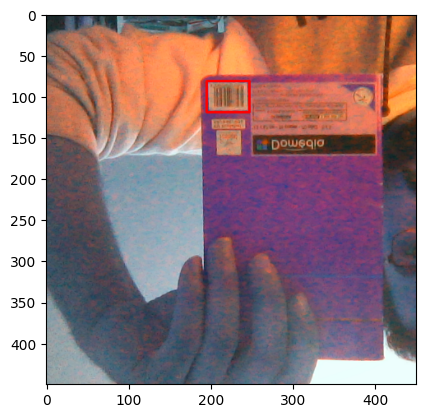

In [96]:
row = aug_data_frame.loc[100]
print(row)
x_min,y_min,x_max,y_max = np.multiply((row.x_min,row.y_min,row.x_max,row.y_max),450).astype(int)
image = cv2.imread(os.path.join("./aug_data/train",row.image))
cv2.rectangle(image,(x_min,y_min),(x_max,y_max),(255,0,0),2)
plt.imshow(image)